In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from datetime import datetime
from tqdm import tqdm_notebook

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GroupShuffleSplit
from sklearn.metrics import confusion_matrix, make_scorer, log_loss
from scipy import sparse

from sklearn.preprocessing import Normalizer

%matplotlib inline

In [2]:
PATH_TO_PROCESSED_DATA = './../data/kaggle_receipts/processed/'

## load data

In [3]:
loaded_train = []
loaded_test = []

features_to_load = [
    ('name_cvect', 'npz'),
    #('name_cvect_mms', 'npz'),
    #('name_cvect_norm', 'npz'),
    #('name_cvect_tw', 'npz'),
    #('name_tfidf', 'npz'),
    ('shop_name', 'npz'),
    ('price', 'csv'),
    #('price_mms', 'csv'),
    #('count' , 'csv'),
    #('dayofweek', 'npz'),
    #('hour', 'npz'),
    #('hour_dayofweek_poly', 'csv'),
]

In [4]:
for (name, tp) in features_to_load:
    if tp == 'npz':
        loaded_train.append(sparse.load_npz(PATH_TO_PROCESSED_DATA + name + '_train.npz'))
        loaded_test.append(sparse.load_npz(PATH_TO_PROCESSED_DATA + name + '_test.npz'))
    elif tp == 'csv':
        loaded_train.append(pd.read_csv(PATH_TO_PROCESSED_DATA + name + '_train.csv', index_col=0))
        loaded_test.append(pd.read_csv(PATH_TO_PROCESSED_DATA + name + '_test.csv', index_col=0))
        
categories_train = pd.read_csv(PATH_TO_PROCESSED_DATA + 'categories_train.csv', index_col=0)
check_id_train = pd.read_csv(PATH_TO_PROCESSED_DATA + 'check_id_train.csv', index_col=0)
id_test = pd.read_csv(PATH_TO_PROCESSED_DATA + 'id_test.csv', index_col=0)

In [5]:
X_train_full = sparse.csr_matrix(sparse.hstack(loaded_train))
X_test_full = sparse.csr_matrix(sparse.hstack(loaded_test))
y_train = categories_train['category']
check_id_train = check_id_train['check_id']
id_test = id_test[['id']]

In [6]:
print(X_train_full.shape)
print(X_test_full.shape)
print(y_train.shape)
print(check_id_train.shape)
print(id_test.shape)

(13682, 14432)
(3000, 14432)
(13682,)
(13682,)
(3000, 1)


In [7]:
with open(PATH_TO_PROCESSED_DATA + 'category_labeler.pkl', 'rb') as category_labeler_file:
    category_labeler = pickle.load(category_labeler_file)

## normalizing dataset

In [8]:
# norm = Normalizer()

# norm.fit(X_train_full)

# X_train_full = norm.transform(X_train_full)
# X_test_full = norm.transform(X_test_full)

## slpit data to cross validation (GroupShuffleSplit)

In [9]:
gss = GroupShuffleSplit(n_splits=5, random_state=0)

In [10]:
gss_splits = list(gss.split(X_train_full, y_train, check_id_train))

## manual param search

In [ ]:
lr_params = [
    {'multi_class': 'multinomial', 'solver': 'sag'},
    {'multi_class': 'multinomial', 'solver': 'saga'},
    {'multi_class': 'multinomial', 'solver': 'newton-cg'},
    {'multi_class': 'multinomial', 'solver': 'lbfgs'},
    {'multi_class': 'ovr', 'solver': 'liblinear'}
]

In [ ]:
for params in tqdm_notebook(lr_params):
    
    estimator = LogisticRegression(**params)

    score = cross_val_score(estimator, 
                            X_train_full, 
                            y_train, 
                            scoring='neg_log_loss', 
                            cv=gss_splits, 
                            n_jobs=-1)

    print(params)
    print('score: mean = {} std = {}'.format(-score.mean(), score.std()))

## 'C' range

In [64]:
#C_range = np.logspace(-0.5, 2.5, 25)
C_range = np.linspace(1.0, 100.0, 250)

for idx, C in enumerate(C_range):
    print('{} -> {}'.format(idx, C))

0 -> 1.0
1 -> 1.3975903614457832
2 -> 1.7951807228915664
3 -> 2.192771084337349
4 -> 2.5903614457831328
5 -> 2.9879518072289155
6 -> 3.3855421686746987
7 -> 3.783132530120482
8 -> 4.1807228915662655
9 -> 4.578313253012048
10 -> 4.975903614457831
11 -> 5.373493975903615
12 -> 5.771084337349397
13 -> 6.168674698795181
14 -> 6.566265060240964
15 -> 6.963855421686747
16 -> 7.36144578313253
17 -> 7.759036144578313
18 -> 8.156626506024097
19 -> 8.55421686746988
20 -> 8.951807228915662
21 -> 9.349397590361447
22 -> 9.74698795180723
23 -> 10.144578313253012
24 -> 10.542168674698795
25 -> 10.939759036144578
26 -> 11.337349397590362
27 -> 11.734939759036145
28 -> 12.132530120481928
29 -> 12.53012048192771
30 -> 12.927710843373495
31 -> 13.325301204819278
32 -> 13.72289156626506
33 -> 14.120481927710843
34 -> 14.518072289156626
35 -> 14.91566265060241
36 -> 15.313253012048193
37 -> 15.710843373493976
38 -> 16.10843373493976
39 -> 16.506024096385545
40 -> 16.903614457831324
41 -> 17.30120481927710

## manual cross validation

In [37]:
%%time

lrs = []
cv_scores = []

for C in tqdm_notebook(C_range):
    
    cur_lr = LogisticRegression(C=C, class_weight='balanced', random_state=14)
    
    cv_score = cross_val_score(cur_lr, X_train_full, y_train, scoring='neg_log_loss', cv=gss_splits, n_jobs=-1)
    
    lrs.append(cur_lr)
    cv_scores.append(-1 * cv_score.mean())

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))


Wall time: 1min 50s


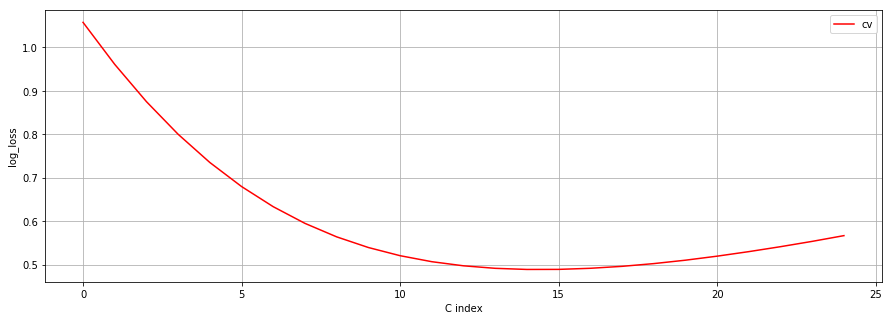

In [38]:
plt.figure(figsize=(15, 5))

plt.plot(range(len(C_range)), cv_scores, color='red', label='cv')

#plt.ylim(0.94, 1.01)
#plt.xlim(18, 22)
plt.xlabel("C index")
plt.ylabel("log_loss")
plt.legend()
plt.grid()
plt.show()

In [39]:
print('best cv score:', np.min(cv_scores))
print('best C:', C_range[np.argmin(cv_scores)])
print('best C index:', np.argmin(cv_scores))

ms_best_estimator = lrs[np.argmin(cv_scores)]

best cv score: 0.4892725562567941
best C: 17.78279410038923
best C index: 14


## manual log_loss function

In [48]:
manual_log_loss = make_scorer(log_loss, needs_proba=True, greater_is_better=False, eps=1e-2)

In [49]:
%%time

mll_lrs = []
mll_cv_scores = []

for C in tqdm_notebook(C_range):
    
    cur_lr = LogisticRegression(C=C, class_weight='balanced', random_state=14)
    
    cv_score = cross_val_score(cur_lr, X_train_full, y_train, scoring=manual_log_loss, cv=gss_splits, n_jobs=-1)
    
    mll_lrs.append(cur_lr)
    mll_cv_scores.append(-1 * cv_score.mean())

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))


Wall time: 1min 48s


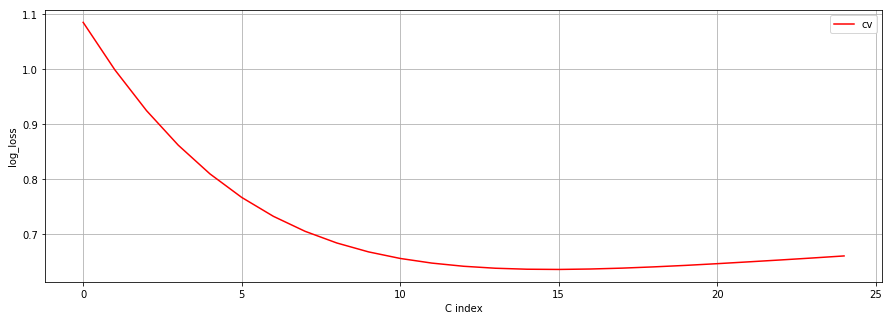

In [50]:
plt.figure(figsize=(15, 5))

plt.plot(range(len(C_range)), mll_cv_scores, color='red', label='cv')

#plt.ylim(0.94, 1.01)
#plt.xlim(18, 22)
plt.xlabel("C index")
plt.ylabel("log_loss")
plt.legend()
plt.grid()
plt.show()

In [51]:
print('best cv score:', np.min(mll_cv_scores))
print('best C:', C_range[np.argmin(mll_cv_scores)])
print('best C index:', np.argmin(mll_cv_scores))

ms_mll_best_estimator = mll_lrs[np.argmin(mll_cv_scores)]

best cv score: 0.6355262734228597
best C: 23.71373705661655
best C index: 15


## custom estimator

In [11]:
# custom_estimator = LogisticRegression(penalty='l2', 
#                                       multi_class='ovr', 
#                                       solver='liblinear', 
#                                       class_weight='balanced', 
#                                       C=18.87391)

custom_estimator = LogisticRegression(class_weight='balanced', C=17.78279)

custom_cv_score = cross_val_score(custom_estimator, X_train_full, y_train, scoring='neg_log_loss', cv=gss_splits, n_jobs=-1)

print('custom_cv_score:', -1 * custom_cv_score.mean())

custom_cv_score: 0.5372982920146528


## refit and analysis

In [12]:
best_estimator = custom_estimator
#best_estimator = ms_mll_best_estimator

In [13]:
%%time

best_estimator.fit(X_train_full, y_train)

Wall time: 1.28 s


LogisticRegression(C=17.78279, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [15]:
# conf_matrix = confusion_matrix(y_train, best_estimator.predict(X_train_full))

# errors_matrix = []

# for true_lbl in range(conf_matrix.shape[0]):
#     for pred_lbl in range(conf_matrix.shape[1]):
#         if true_lbl == pred_lbl: 
#             continue
#         if conf_matrix[true_lbl, pred_lbl] == 0:
#             continue
#         errors_matrix.append([category_labeler.classes_[true_lbl], 
#                               category_labeler.classes_[pred_lbl], 
#                               conf_matrix[true_lbl, pred_lbl]])
    
# errors_df = pd.DataFrame(errors_matrix, columns=['true', 'pred', 'error_count'])
# errors_df = errors_df.sort_values(by=['error_count'], ascending=False)
# errors_df

## make prediction

In [14]:
predictions = best_estimator.predict_proba(X_test_full)

In [15]:
predictions_df = id_test

for idx, category in enumerate(category_labeler.classes_):
    predictions_df = pd.concat([predictions_df, pd.Series(predictions[:, idx], name=category)], axis=1)

In [16]:
timestamp = datetime.now().strftime('%m%d_%H%M')
predictions_df.to_csv('./submissions/submission_{}.csv'.format(timestamp), encoding='utf-8', index=False)